**Import libraries**

In [1]:
from sklearn.datasets import load_digits

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import joblib

import warnings

**Define libraries parameters**

In [2]:
warnings.filterwarnings(action='ignore')

**Define project constants**

In [3]:
RANDOM_STATE =42
N_JOBS = -1

**Load input dataset to perform the analysis**

In [4]:
X,y = load_digits(return_X_y=True)

**Split dataset into training and test sets**

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

**Create pipeline with scaling and model objects**

models ={
    ("Model":RandomForestClassifier()),
    ("Model": KNNClassifier())
}

for model in models:
    pipeline = Pipeline(
        steps=[
            ("Scaler", MinMaxScaler()),
            model
        ]
    )
    pipeline.fit(X=X_train, y=y_train)

In [6]:
base_pipeline = Pipeline(
    steps=[
        ("Scaler", MinMaxScaler()),
        ("Model", RandomForestClassifier(oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE))
    ]
)
base_pipeline.fit(X=X_train, y=y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('Model',
                 RandomForestClassifier(n_jobs=-1, oob_score=True,
                                        random_state=42))])

**Compute predictions on training set**

In [7]:
y_train_pred = base_pipeline.predict(X=X_train)

**Show classification report on training set data**

In [8]:
report =classification_report(y_true=y_train,y_pred=y_train_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       1.00      1.00      1.00       146
           2       1.00      1.00      1.00       142
           3       1.00      1.00      1.00       146
           4       1.00      1.00      1.00       145
           5       1.00      1.00      1.00       145
           6       1.00      1.00      1.00       145
           7       1.00      1.00      1.00       143
           8       1.00      1.00      1.00       139
           9       1.00      1.00      1.00       144

    accuracy                           1.00      1437
   macro avg       1.00      1.00      1.00      1437
weighted avg       1.00      1.00      1.00      1437



**Perform cross validation on base pipeline**

In [9]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
base_cv_scores = cross_val_score(estimator=base_pipeline, X=X_train, y=y_train,
                                 scoring='accuracy', cv=skfold, n_jobs=N_JOBS, verbose=1)
base_cv_scores                                 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.3s finished


array([0.96527778, 0.98611111, 0.97222222, 0.98611111, 0.97222222,
       0.99305556, 0.96527778, 0.97202797, 0.97902098, 0.97902098])

In [10]:
base_pipeline.named_steps

{'Scaler': MinMaxScaler(),
 'Model': RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)}

**Search best parameters for pipeline using random search**
* anche se i risultati in cv sono buoni posso sempre migliorare

In [11]:
params={
    "Model__n_estimators": [50, 100, 200, 250, 500],
    "Model__criterion":["gini", "entropy"], #max_depth non serve perchè gli alberi singoli sono a max dimensione
    "Model__max_features":["sqrt", "log"],
    "Model__class_weight":[None, "balanced"]
}
random_search= RandomizedSearchCV(estimator=base_pipeline, param_distributions=params, n_iter=20,
                                  scoring='accuracy', n_jobs=N_JOBS, cv=skfold, verbose=True, random_state=RANDOM_STATE)
random_search.fit(X=X_train, y=y_train)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('Scaler', MinMaxScaler()),
                                             ('Model',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     oob_score=True,
                                                                     random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'Model__class_weight': [None,
                                                                'balanced'],
                                        'Model__criterion': ['gini', 'entropy'],
                                        'Model__max_features': ['sqrt', 'log'],
                                        'Model__n_estimators': [50, 100, 200,
                                                                250, 500]},
                   random_state=42, scoring='accuracy', verbose=True)

In [12]:
random_search.best_params_

{'Model__n_estimators': 500,
 'Model__max_features': 'sqrt',
 'Model__criterion': 'gini',
 'Model__class_weight': 'balanced'}

**Get the pipeline with the best parameters**

In [13]:
best_pipeline = Pipeline(
    steps=[
        ("Scaler", MinMaxScaler()),
        ("Model", RandomForestClassifier(n_estimators=500, oob_score=True, n_jobs=N_JOBS, random_state=RANDOM_STATE, class_weight='balanced'))
    ]
)
best_pipeline.fit(X=X_train, y=y_train)

Pipeline(steps=[('Scaler', MinMaxScaler()),
                ('Model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500, n_jobs=-1,
                                        oob_score=True, random_state=42))])

**Perform cross validation**

In [14]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
best_cv_scores = cross_val_score(estimator=best_pipeline, X=X_train, y=y_train,
                                 scoring='accuracy', cv=skfold, n_jobs=N_JOBS, verbose=1)
best_cv_scores  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.5s finished


array([0.96527778, 0.99305556, 0.98611111, 0.98611111, 0.97222222,
       0.99305556, 0.97222222, 0.98601399, 0.97902098, 0.97902098])

**Match base and best models**

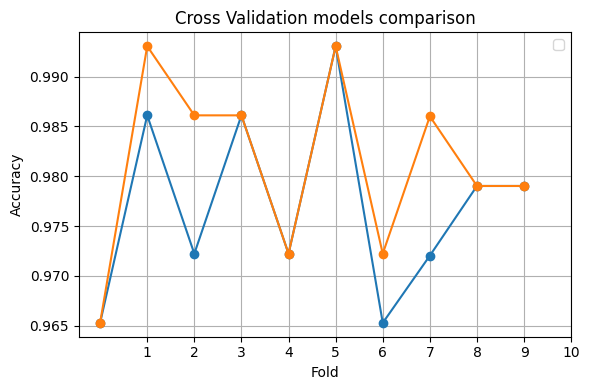

In [15]:
plt.figure(figsize=(6,4))
plt.title("Cross Validation models comparison")
plt.plot(base_cv_scores, marker='o')
plt.plot(best_cv_scores, marker='o')
plt.legend("base model","best model")
plt.xticks(ticks=range(1,11))
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid()
plt.tight_layout()
plt.show()

**Check model performance on test set**

In [16]:
y_pred =best_pipeline.predict(X=X_test)

In [17]:
report =classification_report(y_true=y_test,y_pred=y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        36
           1       0.92      0.97      0.95        36
           2       1.00      1.00      1.00        35
           3       0.97      1.00      0.99        37
           4       0.97      1.00      0.99        36
           5       0.97      1.00      0.99        37
           6       1.00      0.97      0.99        36
           7       0.92      1.00      0.96        36
           8       0.94      0.86      0.90        35
           9       1.00      0.92      0.96        36

    accuracy                           0.97       360
   macro avg       0.97      0.97      0.97       360
weighted avg       0.97      0.97      0.97       360



**Serialize best pipeline**

In [18]:
joblib.dump(value=best_pipeline, filename="models/digit_pipeline.joblib")

['models/digit_pipeline.joblib']